In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata


In [8]:

# Load data - strainmap file from py4DSTEM
strainmap_data = np.load('strainmap_data.npy')

# Define the labels in the correct order
labels = ['e_xx', 'e_yy', 'e_xy', 'theta', 'mask', 'error']

# Create a dictionary to easily access each component
strain_components = {label: strainmap_data[i] for i, label in enumerate(labels)}

# Extract components
e_xx = strain_components['e_xx']
e_yy = strain_components['e_yy']
e_xy = strain_components['e_xy']
theta = strain_components['theta']
mask = strain_components['mask']
error = strain_components['error']

def prepare_data(e_xx, e_yy, e_xy, theta, mask):
    height, width = e_xx.shape
    x = torch.linspace(0, 1, width)
    y = torch.linspace(0, 1, height)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    return (X.flatten(), Y.flatten(), 
            torch.tensor(e_xx.flatten(), dtype=torch.float32),
            torch.tensor(e_yy.flatten(), dtype=torch.float32),
            torch.tensor(e_xy.flatten(), dtype=torch.float32),
            torch.tensor(theta.flatten(), dtype=torch.float32),
            torch.tensor(mask.flatten(), dtype=torch.float32))

x, y, e_xx_tensor, e_yy_tensor, e_xy_tensor, theta_tensor, mask_tensor = prepare_data(e_xx, e_yy, e_xy, theta, mask)

In [11]:
class StrainPINN(nn.Module):
    def __init__(self):
        super(StrainPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4)  # Output e_xx, e_yy, e_xy, theta
        )

    def forward(self, x):
        return self.net(x)

def pinn_loss(model, x, y, e_xx_true, e_yy_true, e_xy_true, theta_true, mask):
    inputs = torch.stack([x, y], dim=1)
    outputs = model(inputs)
    e_xx_pred, e_yy_pred, e_xy_pred, theta_pred = outputs.unbind(dim=1)
    
    # Data loss (only consider valid points according to mask)
    mse_loss = torch.mean(mask * (torch.square(e_xx_pred - e_xx_true) +
                                  torch.square(e_yy_pred - e_yy_true) +
                                  torch.square(e_xy_pred - e_xy_true) +
                                  torch.square(theta_pred - theta_true)))
    
    # You can add PDE constraints here if needed
    
    return mse_loss

def train_pinn(x, y, e_xx, e_yy, e_xy, theta, mask, n_epochs=10000):
    model = StrainPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = pinn_loss(model, x, y, e_xx, e_yy, e_xy, theta, mask)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

def visualize_results(model, x, y, e_xx_true, e_yy_true, e_xy_true, theta_true):
    with torch.no_grad():
        inputs = torch.stack([x, y], dim=1)
        outputs = model(inputs)
        e_xx_pred, e_yy_pred, e_xy_pred, theta_pred = outputs.unbind(dim=1)

    components = ['e_xx', 'e_yy', 'e_xy', 'theta']
    true_data = [e_xx_true, e_yy_true, e_xy_true, theta_true]
    pred_data = [e_xx_pred, e_yy_pred, e_xy_pred, theta_pred]

    fig, axs = plt.subplots(4, 2, figsize=(12, 20))
    for i, (component, true, pred) in enumerate(zip(components, true_data, pred_data)):
        im_true = axs[i, 0].imshow(true.reshape(90, 45), cmap='viridis')
        axs[i, 0].set_title(f'True {component}')
        plt.colorbar(im_true, ax=axs[i, 0])
        
        im_pred = axs[i, 1].imshow(pred.reshape(90, 45), cmap='viridis')
        axs[i, 1].set_title(f'Predicted {component}')
        plt.colorbar(im_pred, ax=axs[i, 1])
    
    plt.tight_layout()
    plt.show()

def interpolation_analysis(x, y, e_xx, e_yy, e_xy, theta, mask, trained_model):
    # Create a fine grid for interpolation
    x_fine = np.linspace(0, 1, 180)
    y_fine = np.linspace(0, 1, 90)
    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

    # Prepare input data for interpolation
    points = np.column_stack((x.numpy(), y.numpy()))
    values = {
        'e_xx': e_xx.numpy(),
        'e_yy': e_yy.numpy(),
        'e_xy': e_xy.numpy(),
        'theta': theta.numpy()
    }

    # Interpolate using different methods
    methods = ['nearest', 'linear', 'cubic']
    interpolated_results = {}

    for method in methods:
        interpolated_results[method] = {}
        for component, value in values.items():
            interpolated_results[method][component] = griddata(points, value, (X_fine, Y_fine), method=method)

    # PINN prediction on fine grid
    with torch.no_grad():
        x_fine_torch = torch.from_numpy(X_fine.flatten()).float()
        y_fine_torch = torch.from_numpy(Y_fine.flatten()).float()
        inputs = torch.stack([x_fine_torch, y_fine_torch], dim=1)
        outputs = trained_model(inputs)
        pinn_results = {
            'e_xx': outputs[:, 0].reshape(X_fine.shape),
            'e_yy': outputs[:, 1].reshape(X_fine.shape),
            'e_xy': outputs[:, 2].reshape(X_fine.shape),
            'theta': outputs[:, 3].reshape(X_fine.shape)
        }

    # Visualize results
    components = ['e_xx', 'e_yy', 'e_xy', 'theta']
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))

    for i, component in enumerate(components):
        # Original data
        im = axs[i, 0].imshow(values[component].reshape(90, 45), cmap='viridis', extent=[0, 1, 0, 1])
        axs[i, 0].set_title(f'Original {component}')
        plt.colorbar(im, ax=axs[i, 0])

        # Interpolation methods
        for j, method in enumerate(methods, start=1):
            im = axs[i, j].imshow(interpolated_results[method][component], cmap='viridis', extent=[0, 1, 0, 1])
            axs[i, j].set_title(f'{method.capitalize()} Interpolation')
            plt.colorbar(im, ax=axs[i, j])

        # PINN results
        im = axs[i, 3].imshow(pinn_results[component], cmap='viridis', extent=[0, 1, 0, 1])
        axs[i, 3].set_title('PINN Prediction')
        plt.colorbar(im, ax=axs[i, 3])

    plt.tight_layout()
    plt.show()

    # Calculate and print error metrics
    def calculate_metrics(pred, true):
        # Ensure pred and true have the same shape
        if pred.shape != true.shape:
            # Assuming pred is the higher resolution one
            pred = pred[::2, ::2]  # Downsample pred to match true's shape
        
        mse = np.mean((pred - true)**2)
        mae = np.mean(np.abs(pred - true))
        return mse, mae

    print("Error Metrics:")
    for component in components:
        print(f"\n{component}:")
        true_data = values[component].reshape(90, 45)
        for method in methods:
            interp_data = interpolated_results[method][component]
            mse, mae = calculate_metrics(interp_data, true_data)
            print(f"  {method.capitalize()} Interpolation - MSE: {mse:.6f}, MAE: {mae:.6f}")
        
        pinn_data = pinn_results[component].numpy()
        mse, mae = calculate_metrics(pinn_data, true_data)
        print(f"  PINN Prediction - MSE: {mse:.6f}, MAE: {mae:.6f}")



Epoch 0, Loss: 0.095835
Epoch 100, Loss: 0.020562
Epoch 200, Loss: 0.019107
Epoch 300, Loss: 0.018609
Epoch 400, Loss: 0.018594
Epoch 500, Loss: 0.018583
Epoch 600, Loss: 0.018575
Epoch 700, Loss: 0.018569
Epoch 800, Loss: 0.018568
Epoch 900, Loss: 0.018557
Epoch 1000, Loss: 0.018550
Epoch 1100, Loss: 0.018611
Epoch 1200, Loss: 0.018537
Epoch 1300, Loss: 0.018531
Epoch 1400, Loss: 0.018527
Epoch 1500, Loss: 0.018643
Epoch 1600, Loss: 0.018523
Epoch 1700, Loss: 0.018520
Epoch 1800, Loss: 0.018516
Epoch 1900, Loss: 0.018550
Epoch 2000, Loss: 0.018508
Epoch 2100, Loss: 0.018499
Epoch 2200, Loss: 0.018591
Epoch 2300, Loss: 0.018475
Epoch 2400, Loss: 0.018435
Epoch 2500, Loss: 0.018453
Epoch 2600, Loss: 0.018343
Epoch 2700, Loss: 0.018139
Epoch 2800, Loss: 0.018100
Epoch 2900, Loss: 0.017763
Epoch 3000, Loss: 0.017622
Epoch 3100, Loss: 0.017317
Epoch 3200, Loss: 0.017284
Epoch 3300, Loss: 0.016977
Epoch 3400, Loss: 0.016815
Epoch 3500, Loss: 0.016838
Epoch 3600, Loss: 0.016768
Epoch 3700, L

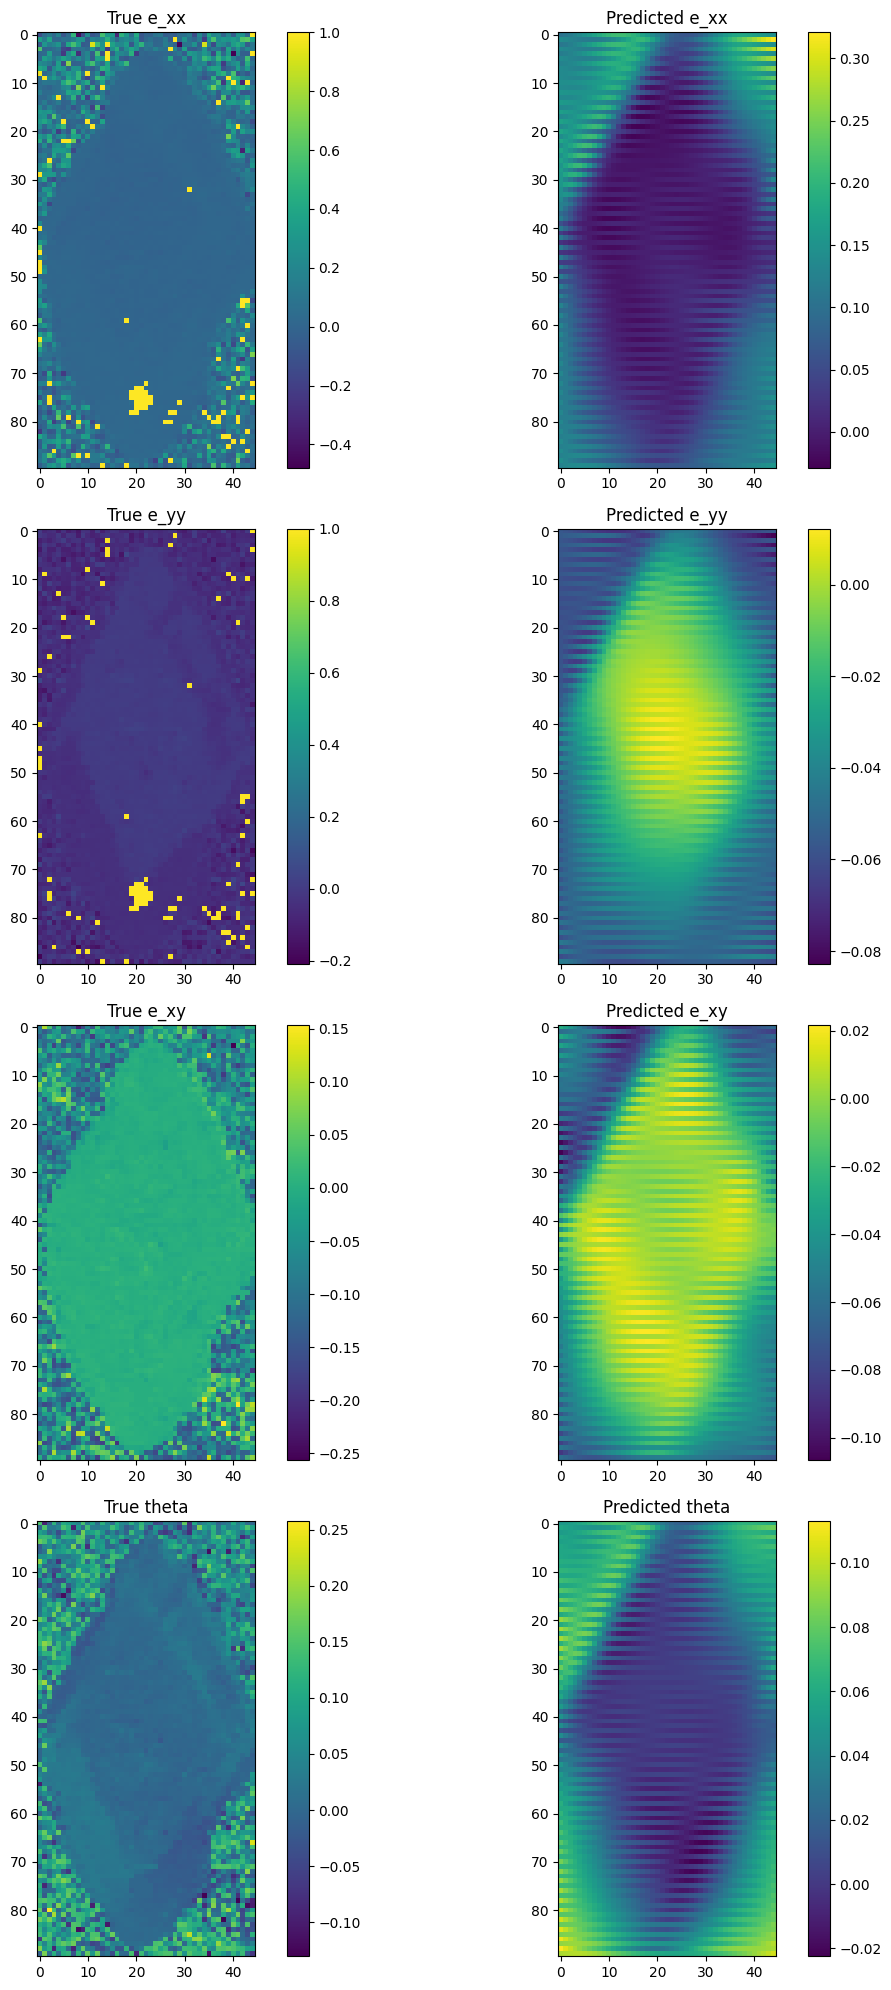

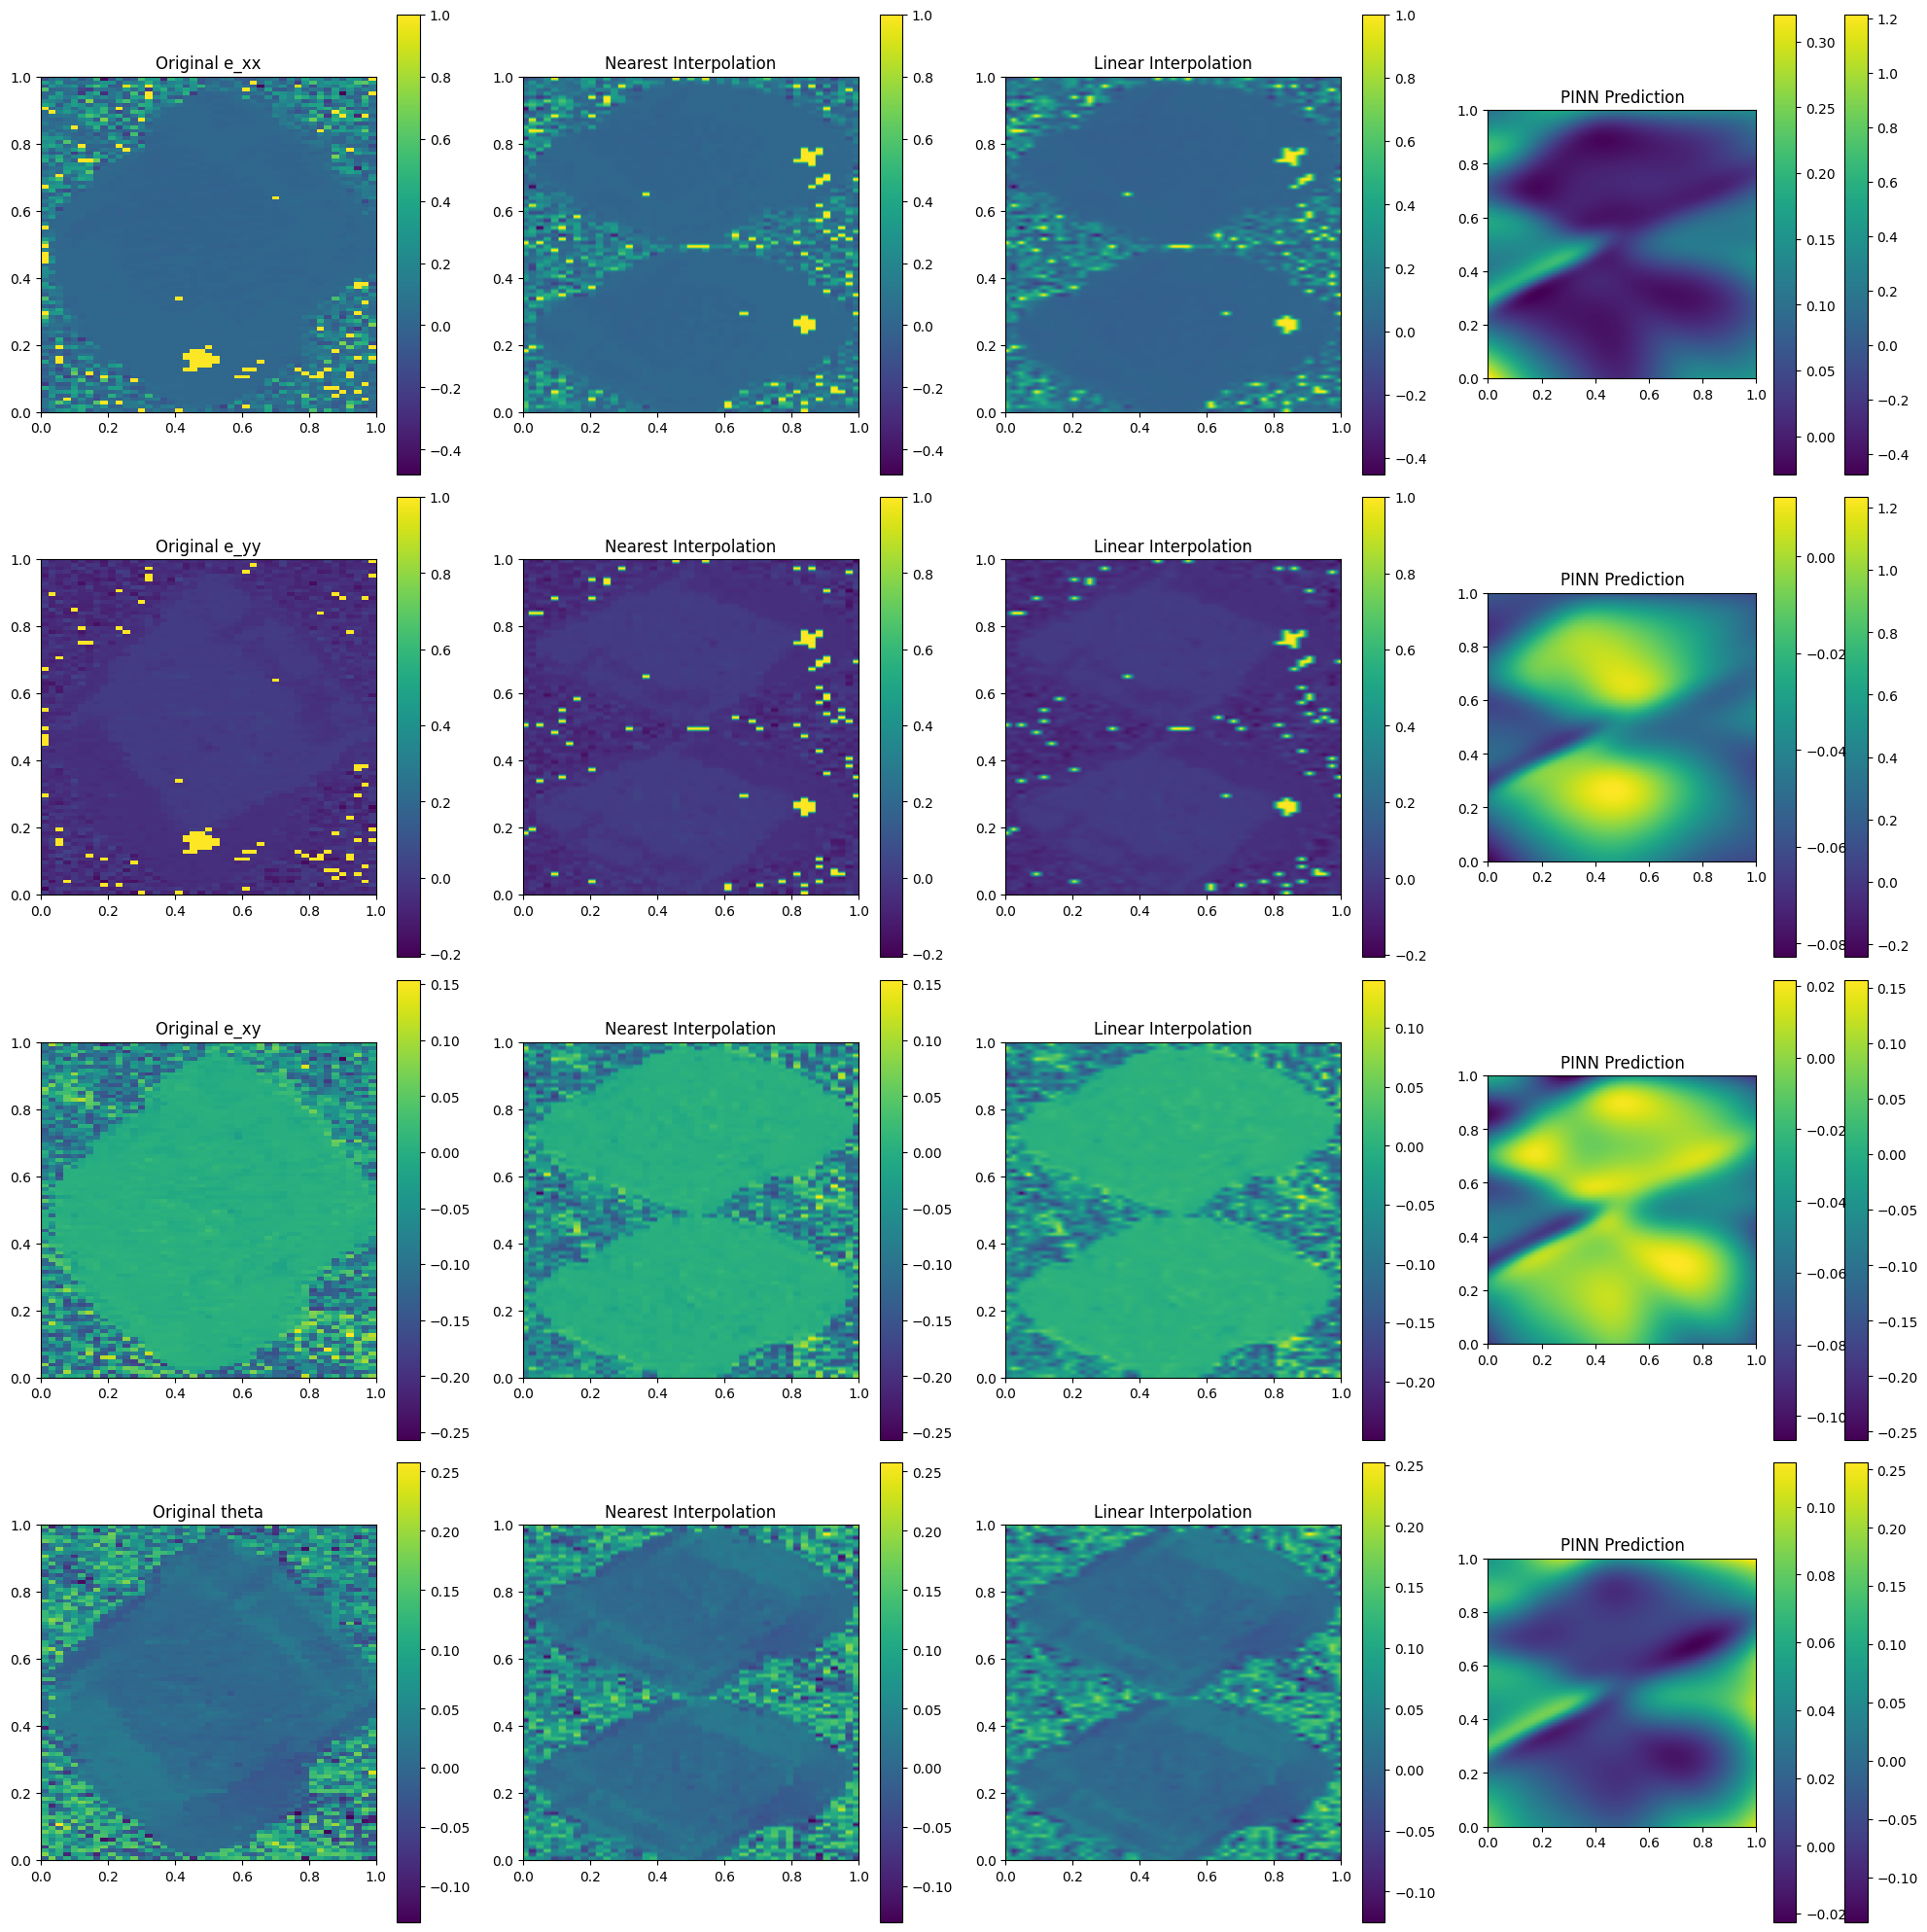

Error Metrics:

e_xx:


ValueError: operands could not be broadcast together with shapes (45,90) (90,45) 

In [12]:
# Train the model
trained_model = train_pinn(x, y, e_xx_tensor, e_yy_tensor, e_xy_tensor, theta_tensor, mask_tensor)

# Visualize results
visualize_results(trained_model, x, y, e_xx_tensor, e_yy_tensor, e_xy_tensor, theta_tensor)

# Perform interpolation analysis
interpolation_analysis(x, y, e_xx_tensor, e_yy_tensor, e_xy_tensor, theta_tensor, mask_tensor, trained_model)